## **Submission Kedua Kelas Machine Learning Intermediate**

Nama: Muhammad Fayzul Haq <br>
Tahun Pengerjaan: Januari 2024


dataset : https://www.kaggle.com/datasets/meetnagadia/apple-stock-price-from-19802021

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_train = pd.read_csv('appleStock.csv')
data_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


### Informasi tambahan
- Open: It is the price at which the financial security opens in the market when trading begins.
- High : The high is the highest price at which a stock traded during a period.
- Low : The low is the lowest price at which a stock traded during a period.
- CLose : Closing price generally refers to the last price at which a stock trades during a regular trading session.
- Adj Close : The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting.
- Volume : Volume measures the number of shares traded in a stock or contracts traded in futures or options

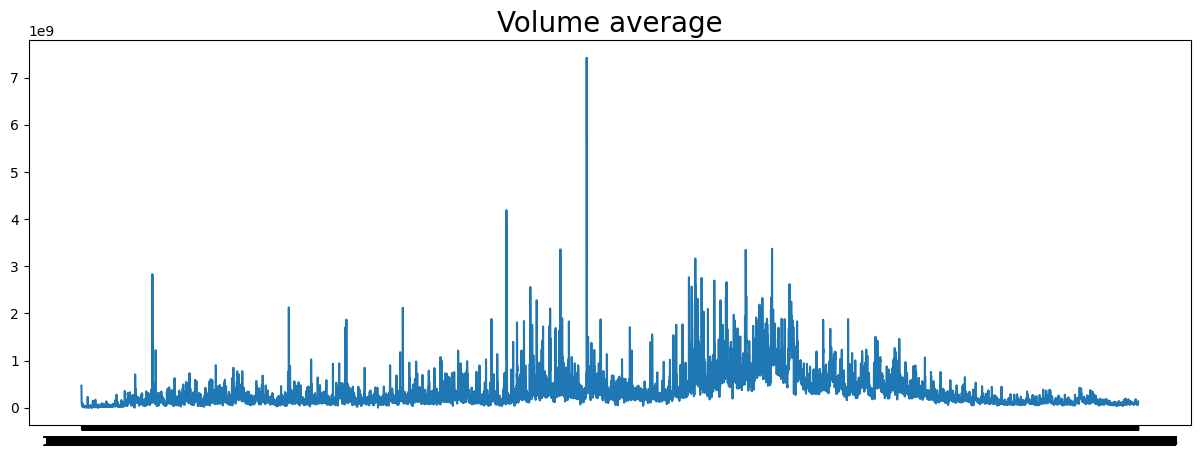

In [3]:
dates = data_train['Date'].values
volume  = data_train['Volume'].values


plt.figure(figsize=(15,5))
plt.plot(dates, volume)
plt.title('Volume average',
          fontsize=20);

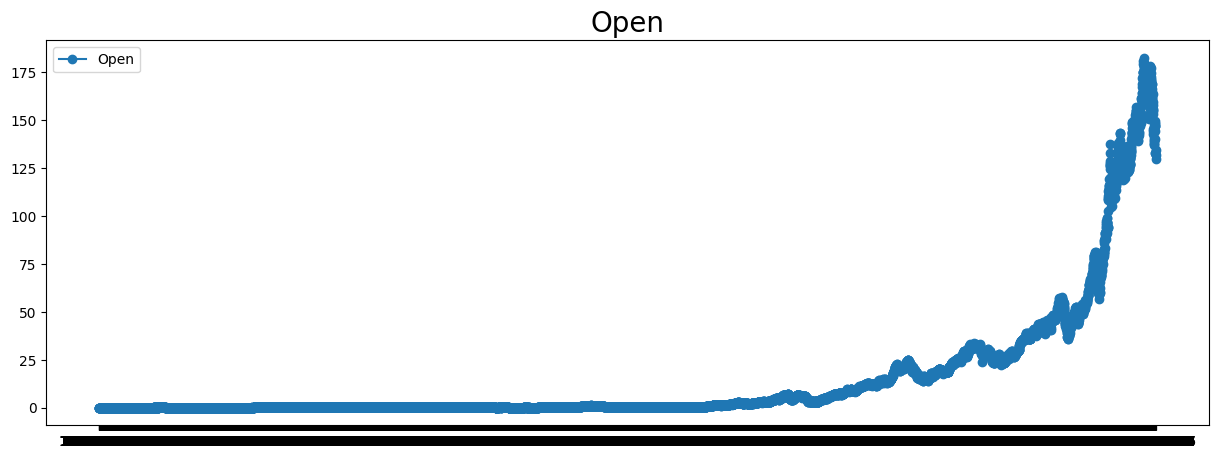

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, data_train['Open'].values, linestyle="-", marker="o", label="Open")
plt.legend()
plt.title('Open',fontsize=20);
plt.show()

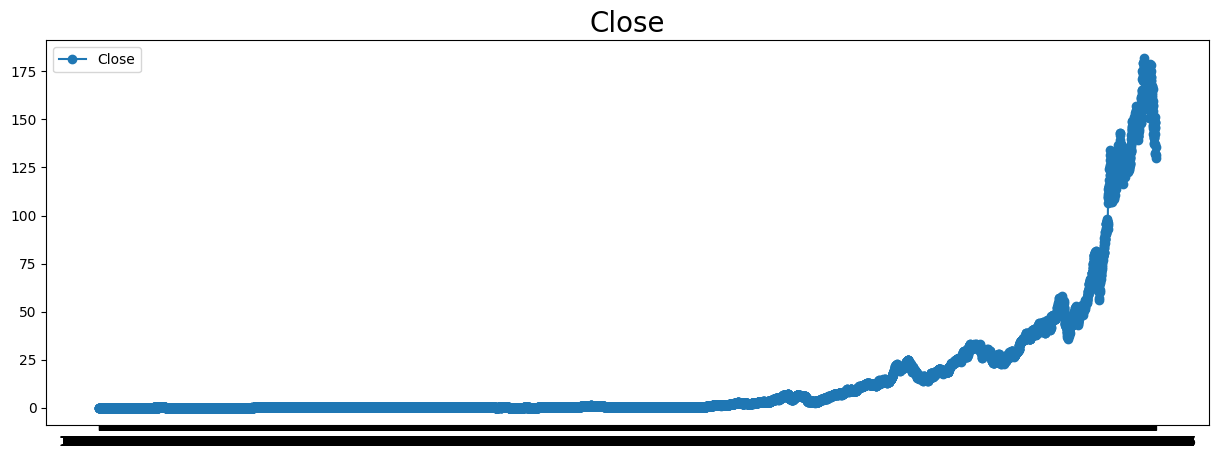

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, data_train['Close'].values, linestyle="-", marker="o", label="Close")
plt.legend()
plt.title('Close',fontsize=20);
plt.show()

In [5]:
newdf = pd.read_csv('appleStock.csv', index_col="Date", parse_dates=True)
newdf.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000


## **Grafik Rata-rata di setiap bulan**

<Figure size 1500x500 with 0 Axes>

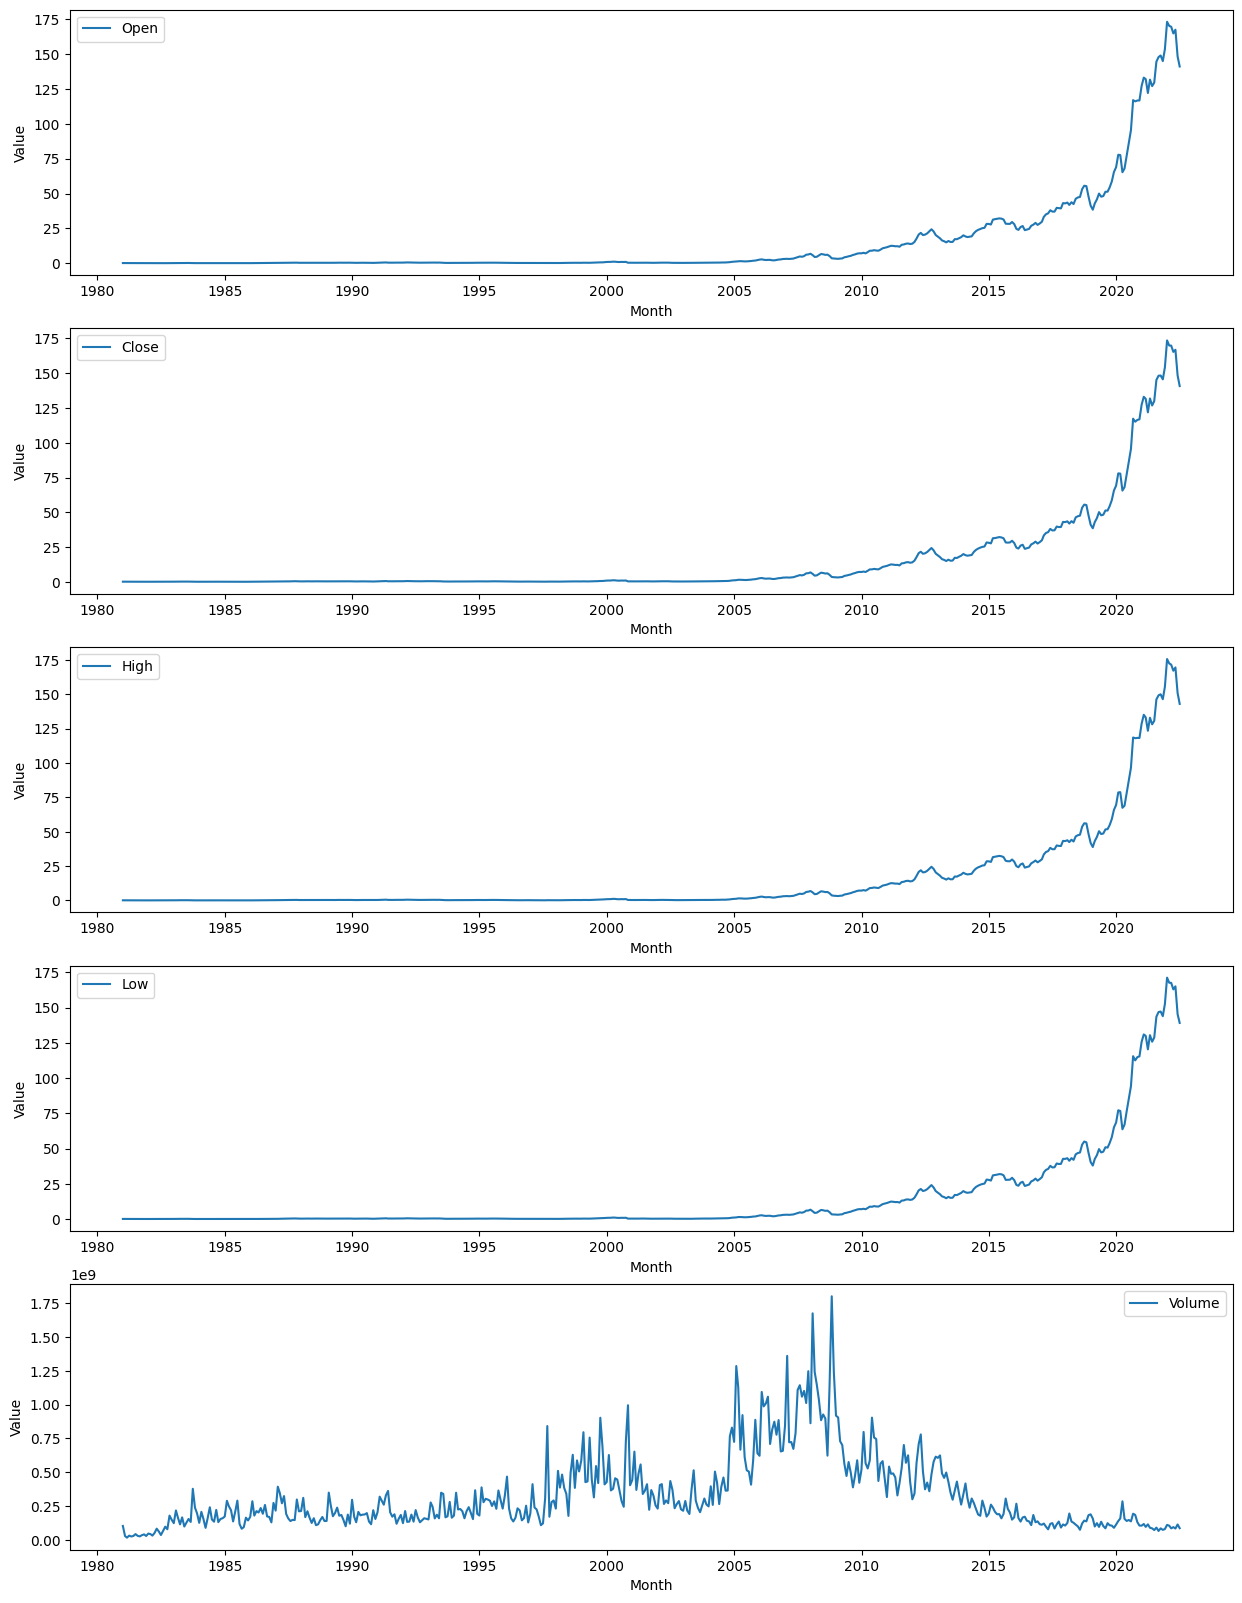

In [ ]:
plt.figure(figsize=(15,5))
df_monthly_means = newdf.groupby(pd.Grouper(level="Date", freq="M")).mean()

fig, axes = plt.subplots(5, 1, figsize=(15, 20))

# Plot data untuk setiap kolom
axes[0].plot(df_monthly_means["Open"], label="Open")
axes[1].plot(df_monthly_means["Close"], label="Close")
axes[2].plot(df_monthly_means["High"], label="High")
axes[3].plot(df_monthly_means["Low"], label="Low")
axes[4].plot(df_monthly_means["Volume"], label="Volume")

for ax in axes:
    ax.set_xlabel("Month")
    ax.set_ylabel("Value")
    ax.legend()

plt.show()

In [6]:
data_train['Date'] = pd.to_datetime(data_train['Date'])

tanggal_awal = pd.to_datetime('2024-01-27')
data_train['Date'] = (data_train['Date'] - tanggal_awal).dt.days

In [7]:
data_train.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,-19750,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,-19750,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,-19750,0.113281,0.113281,0.112723,0.112723,0.087983,105728000


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  int64  
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 572.6 KB


In [9]:
min_max_scaler = MinMaxScaler()
data_train_normalized = min_max_scaler.fit_transform(data_train)

fungsi di bawah yang dapat mengubah data kita menjadi format yang dapat diterima oleh model. Fungsi di bawah menerima sebuah series/atribut kita yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.

In [10]:
data_train_normalized_df = pd.DataFrame(data_train_normalized, columns=data_train.columns)

In [11]:
threshold_mae = (data_train_normalized_df['Open'].max() - data_train_normalized_df['Open'].min()) * 10/100
print(threshold_mae)

0.1


In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < threshold_mae and logs.get('val_mae') >= 0.34):
            print("\nMAE telah mencapai <10%!")
            self.model.stop_training = True

callbacks = myCallback()

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
WINDOW_SIZE = 60
BATCH_SIZE = 100
SHUFFLE_BUFFER = 1000

In [15]:
X_train_normalized, X_val_normalized, y_train, y_val = train_test_split(data_train_normalized_df['Open'], data_train_normalized_df['Date'], test_size=0.2, shuffle=False)

In [16]:
X_train_windowed_normalized = windowed_dataset(X_train_normalized, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
X_val_windowed_normalized = windowed_dataset(X_val_normalized, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

In [17]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
  tf.keras.layers.LSTM(30),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            14880     
                                                                 
 lstm_1 (LSTM)               (None, 30)                10920     
                                                                 
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 27051 (105.67 KB)
Trainable params: 27051 (105.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
%matplotlib inline

Epoch 1/10
84/84 [==============================] - 8s 66ms/step - loss: 5.5622e-04 - mae: 0.0152 - val_loss: 0.1048 - val_mae: 0.3726
Epoch 2/10
84/84 [==============================] - 6s 65ms/step - loss: 5.0939e-04 - mae: 0.0138 - val_loss: 0.1036 - val_mae: 0.3693
Epoch 3/10
84/84 [==============================] - 6s 64ms/step - loss: 4.7716e-04 - mae: 0.0138 - val_loss: 0.1026 - val_mae: 0.3666
Epoch 4/10
84/84 [==============================] - 5s 59ms/step - loss: 4.5404e-04 - mae: 0.0141 - val_loss: 0.1018 - val_mae: 0.3642
Epoch 5/10
84/84 [==============================] - 5s 64ms/step - loss: 4.3694e-04 - mae: 0.0144 - val_loss: 0.1011 - val_mae: 0.3623
Epoch 6/10
84/84 [==============================] - 5s 59ms/step - loss: 4.2466e-04 - mae: 0.0147 - val_loss: 0.1005 - val_mae: 0.3607
Epoch 7/10
84/84 [==============================] - 5s 61ms/step - loss: 4.1492e-04 - mae: 0.0150 - val_loss: 0.1000 - val_mae: 0.3594
Epoch 8/10
84/84 [==============================] - 5s 

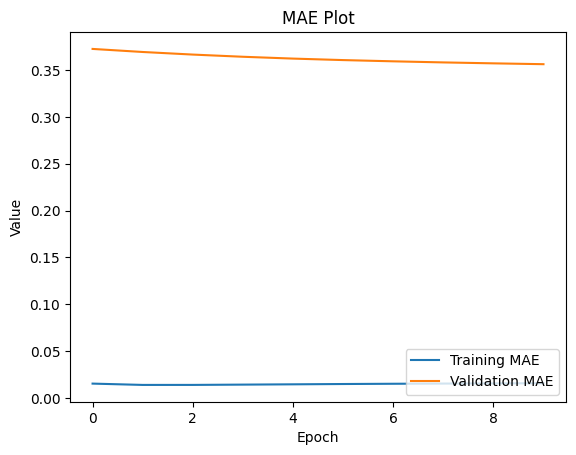

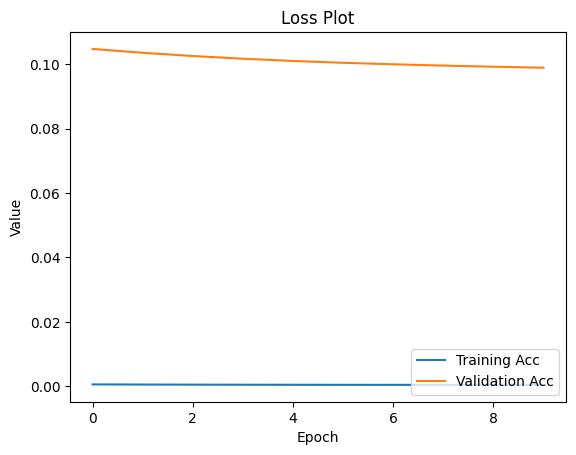

In [21]:
start_time = time.time()

history = model.fit(X_train_windowed_normalized, epochs=10, validation_data=X_val_windowed_normalized)
# history = model.fit(X_train_windowed_normalized, epochs=10, validation_data=X_val_windowed_normalized, callbacks=[callbacks])

end_time = time.time()
training_time = end_time - start_time

print(f"Waktu pelatihan: {training_time / 60:.2f} menit")

#Membuat accuracy plot
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title(f"MAE Plot")
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

# Membuat loss plot
plt.plot(history.history["loss"], label='Training Acc')
plt.plot(history.history["val_loss"], label='Validation Acc')
plt.title(f"Loss Plot")
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()
